# Import packages

In [3]:
l = ["provide","provide","test"]
",".join(list(set(l)))

'provide,test'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import re
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('words')
import random
import mailparser
import requests

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Import Enron emails

## Import originally labeled emails

In [3]:
emails_df = pd.DataFrame({"message" : [],
                         "category" : []})
for i in range(1,9):
    path_data = f'../../raw_data/enron/emails/txt_files_categories/all_txt_files{i}.txt'
    with open(path_data) as f:
        contents = f.read()
        emails_cat = ["Message-ID: " + email for email in contents.split("Message-ID: ") if email]
        emails_df = pd.concat([emails_df, pd.DataFrame({"message" : emails_cat,
                         "category" : int(i)})]).reset_index(drop=True)

## Import model-labeled emails

In [4]:
emails_model_df = pd.read_csv("../../raw_data/new_emails_labeled.csv")
emails_model_df["category"] = 0

# Import conversational messages

## Conversational messages dataset n°1

Source : https://github.com/alexa/Topical-Chat

In [5]:
r = requests.get('https://raw.githubusercontent.com/alexa/Topical-Chat/master/conversations/train.json').json()

message_l = []
for key in r.keys():
    for message in r[key]['content']:
        message_l.append(message["message"])
conv_message_one_df = pd.DataFrame({"body":message_l})
conv_message_one_df.head()

,body
0,Are you a fan of Google or Microsoft?
1,Both are excellent technology they are helpful...
2,"I'm not a huge fan of Google, but I use it a ..."
3,Google provides online related services and pr...
4,"Yeah, their services are good. I'm just not a ..."


Example :

In [6]:
conv_message_one_df.sample()["body"].values[0]

'yeah that is for sure very different. even in the uk not all men could vote intul 1918. i wonder how one qualified'

## Conversational messages dataset n°2

Source : https://www.kaggle.com/datasets/thedevastator/unlock-the-creative-power-of-dynamic-dialogues

In [7]:
path_train = f'../../raw_data/conv_messages_train.csv'
path_test = f'../../raw_data/conv_messages_test.csv'
conv_message_two_df_train = pd.read_csv(path_train)
conv_message_two_df_test = pd.read_csv(path_test)
conv_message_two_raw_df = pd.concat([conv_message_two_df_test, conv_message_two_df_train]).reset_index(drop=True)

mess = []
for i in range(0,len(conv_message_two_raw_df)):
    mess.append("".join(conv_message_two_raw_df.loc[i,"personas"]).replace("[","").replace("]","").replace("'",""))
    mess.append("".join(conv_message_two_raw_df.loc[i,"previous_utterance"]).replace("[","").replace("]","").replace("'",""))
    mess.append("".join(conv_message_two_raw_df.loc[i,"free_messages"]).replace("[","").replace("]","").replace("'",""))
    mess.append("".join(conv_message_two_raw_df.loc[i,"guided_messages"]).replace("[","").replace("]","").replace("'",""))
conv_message_two_df = pd.DataFrame({"body":mess})
conv_message_two_df.head()

,body
0,i hate talking to people. i believe dragons ar...
1,"Wow, I am never shy. Do you have anxiety?\n ""Y..."
2,and why is that?\n interesting but I know how ...
3,"""I think its because in my head, I think every..."
4,i have three daughters. my wife and i like to ...


Example :

In [8]:
conv_message_two_df.sample()["body"].values[0]

'"I really dont get to see that kind of thing often since I just run a custom upholstery shop."\n "Really? Thats awesome. What was the question?"\n Cool. And what is the answer?\n Oh wow. I hate the way that stuff sounds when my kids take their shoes off.\n Hey, good for you!\n "One of them is six and the other is four. Its tough being a single mom."'

In [9]:
conv_message_two_df.shape

(23196, 1)

## Concatenating conversational messages

Creating a dataset of **20 000** messages from conversational messages **n°1** and **20 000** from conversational messages **n°2**

In [10]:
n = 20000
conv_message_df = pd.concat([conv_message_one_df.sample(n), conv_message_two_df.sample(n)]).reset_index(drop=True)
conv_message_df.shape

(40000, 1)

Example :

In [11]:
conv_message_df.sample()["body"].values[0]

'it does but I am not really into all of that just the exercise part of it, not the spiritual\n I read somewhere that it dates back to like the 6th or 5th centuries BCE in India.'

## Testing other dataset...

In [12]:
path_data = '../../raw_data/Social Conversation (csv).csv'
df_test = pd.read_csv(path_data, encoding="Latin-1")
df_test.sample()["??"].values[0]

'Worried'

In [13]:
path_data = '../../raw_data/Emails.csv'
df_test = pd.read_csv(path_data, encoding="Latin-1")
df_test.sample()["RawText"].values[0]

'UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739608\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.\nRELEASE IN\nPART B6\nFrom: Sullivan, Jacobi <SullivanJJOstate.goy>\nSent: Tuesday, March 29, 2011 10:41 PM\nTo:\nSubject: Fw: Libyan\nFyi\n-- Original Message â\x80\x94\nFrom: Gordon, Philip\nSent: Tuesday, March 29, 201105:36 PM\nTo Rottman, Jeffrey D; Burns, William J; Sullivan, Jacob J\nSubject: Re: Libyan\now says the issue of the visitor is "more complicated than they thought" and he prefers to send me a secure\nmessage in the morning. Will let you know.\nMeanwhile, press here all about whether US/coalition going to warm rebels" based on HRC comments about "no\ndecision yet, resolution allows that". Tomorrow\'s Guardian headline is "Coalition ready to arm rebellion if Gadafy clings\nto power". Don\'t know if playing same way back home.\n--- Original Me

# Parsing emails

In [14]:
def extract_date(email):
    mail = mailparser.parse_from_string(email)
    date = mail.date
    return date

def extract_sender(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.from_) > 0:
        sender = mail.from_[0][1]
    else:
        sender = mail.from_
    return sender

def extract_recipients(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.to) > 0:
        to = ",".join([rec[1] for rec in mail.to])
    else:
        to = mail.to
    return to

def extract_header(email):
    mail = mailparser.parse_from_string(email)
    header = mail.subject
    return header

def extract_body(email):
    mail = mailparser.parse_from_string(email)
    body = mail.body
    return body

**Parsing labeled emails**

In [15]:
emails_df_parsed = pd.DataFrame()
emails_df_parsed["ID"] = emails_df["message"].apply(lambda x: re.search(r'\d+',x)[0])
emails_df_parsed["date"] = emails_df["message"].apply(extract_date)
emails_df_parsed["from"] = emails_df["message"].apply(extract_sender)
emails_df_parsed["to"] = emails_df["message"].apply(extract_recipients)
emails_df_parsed["header"] = emails_df["message"].apply(extract_header)
emails_df_parsed["body"] = emails_df["message"].apply(extract_body)
emails_df_parsed["category"] = emails_df["category"]
emails_df_parsed.head()

Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' 

,ID,date,from,to,header,body,category
0,197504,1999-10-18 08:47:00,steven.kean@enron.com,"mark.schroeder@enron.com,kenneth.lay@enron.com...",Translation of articles,---------------------- Forwarded by Steven J K...,1.0
1,11991339,2001-03-05 16:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0
2,7106753,2001-03-06 08:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
3,21267718,2001-03-06 19:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
4,20866019,2001-03-06 03:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0


# EDA emails


In [16]:
num_email_per_cat = emails_df_parsed["category"].value_counts().sort_index()
weight_email_per_cat = emails_df_parsed["category"].value_counts(normalize=True).sort_index()
num_mail_df = pd.DataFrame({"number of emails" : num_email_per_cat.values,
             "% of total" : round(weight_email_per_cat,2)}, index = num_email_per_cat.index)
num_mail_df.loc["Total"] = num_mail_df.sum()
num_mail_df

,number of emails,% of total
1.0,839.0,0.49
2.0,38.0,0.02
3.0,102.0,0.06
4.0,480.0,0.28
5.0,74.0,0.04
6.0,144.0,0.08
7.0,21.0,0.01
8.0,18.0,0.01
Total,1716.0,0.99


Keeping only **business-related** categories and attributing **category 0** for these emails:

In [17]:
emails_business_df = emails_df_parsed[emails_df_parsed["category"].isin([1,4,5,6])][["body","category"]]
emails_business_df["category"] = 0
emails_business_df.head()

,body,category
0,---------------------- Forwarded by Steven J K...,0
1,In anticipation of potential litigation involv...,0
2,Julia and Steve--here are some questions I've ...,0
3,Julia and Steve--here are some questions I've ...,0
4,In anticipation of potential litigation involv...,0


# EDA conversational messages

Affecting **category 1** to conversational messages :

In [18]:
conv_message_df["category"] = 1
conv_message_df.head()

,body,category
0,Wow that is a long time. I had one for 3 year...,1
1,"lol good plan, well watch out for the fly and ...",1
2,Yeah and he must love to read since he spent s...,1
3,I have been a big fan of the Patriots since Br...,1
4,That must be how he developed his famous skyho...,1


In [19]:
length_message = [len(mess) for mess in conv_message_df["body"]]
print("Average message length :", round(np.average(length_message),0), "characters")

Average message length : 174.0 characters


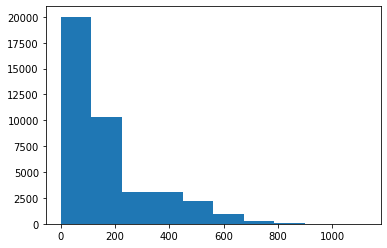

In [20]:
length_message = [len(mess) for mess in conv_message_df["body"]]
plt.hist(length_message);

# Concatenating emails & messages

In [21]:
df = pd.concat([emails_business_df,emails_model_df[["body","category"]],conv_message_df], axis=0).reset_index(drop=True)
df.sample(5)

,body,category
39703,Rachel:\n\nMark Taylor will finalize all issue...,0
77913,i like to learn the history of the buildings.\...,1
61203,I love google! It's funny. The company starte...,1
60998,Nope. I never thought about it. Do you?,1
7546,EXECUTIVE SUMMARY\n?\tA New MOU Takes Shape in...,0


In [40]:
df.category.value_counts()

0    41491
1    40000
Name: category, dtype: int64

In [28]:
emails_model_df[["body","category"]].loc[1234,"body"]

'ARE YOU SINGLE?\nVisit the web\'s favorite meeting place.\nThousands and thousands of people are developing quality relationships at this very moment...all from the comfort and safety of home.\nClick Here to create a FREE profile on Dream Mates and meet that special someone right now!\nhttp://www.play4keeps.com/rd.cgi?dreammates\n\n===========================================\n\nSign Up for our Games and Get $10 FREE!\nhttp://www.play4keeps.com/rd.cgi?cashgames\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<<<>>> <<<>>> <<<>>> <<<>>> <<<>>> <<<>>> <<<>>> <<<>>> <<<>>> <<<>>>\n* To remove yourself from this mailing list, point your browser to:\nhttp://i.pm0.net/remove?freebiecash:14\n* Enter your email address (don.baughman@enron.com) in the field\nprovided and click "Unsubscribe". The mailing list ID is "freebiecash:14".\n\nOR...\n\n* Reply to this message with the word "remove" in the subject line.\n\nThis message was sent to address don.baughman@enron.com\nX-PMG-Recipient: don.baughman@enro

In [41]:
df.to_csv("message_business_perso.csv")

# Preprocessing

## Cleaning

In [42]:
def clean_email(email):

    # Remove mentions
    email = re.sub(r'@\w+', '', email)
    # Remove urls
    email = re.sub(r'http\S+', ' ', email)
    # Remove digits
    email = re.sub("\d+", " ", email)
    # Remove backline character
    email = email.replace('\n', ' ')
    # Remove forwarded emails
#     email = re.sub("Forwarded by.*$",' ', email)
#     email = re.sub("Original Message.*$",' ', email)
    # Remove digits between brackets
    email = re.sub(r'<.*>', '', email)
    # Remove punctuations
    email = email.translate(str.maketrans(" ", " ", punctuation))
    email = email.lower()
    # Remove some keyword
    elements_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
     'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
     'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --', '-', '/', '\n', 'Re:', 'FW:']
    for element in elements_to_drop:
        email = email.replace(element, ' ')

    return email

In [43]:
df_cleaned = df.loc[df["body"].notna()]
df_cleaned["body"] = df_cleaned["body"].apply(clean_email)

## Stopword removal

In [44]:
def stopword_removal(email):

    stop_words = set(stopwords.words('english')) 

    email = email.split()
    filtered_sentence = ""

    for w in email: 
        if w not in stop_words: 
            filtered_sentence = filtered_sentence + w +" "

    return filtered_sentence

def unknown_word(email):
    
    words = set(nltk.corpus.words.words())

    filtered_sentence = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())
    
    return filtered_sentence

In [45]:
df_cleaned["body"] = df_cleaned["body"].apply(stopword_removal)
# df_cleaned["body"] = df_cleaned["body"].apply(unknown_word)

## Tokenizing

In [46]:
df_cleaned["body"] = df_cleaned["body"].apply(word_tokenize)

## Lemmatizing

In [47]:
def lemmatizing(email):
    
    # 1 - Lemmatizing the verbs
    verb_lemmatized = [                  
    WordNetLemmatizer().lemmatize(word, pos = "v") # v --> verbs
    for word in email   
    ]

    # 2 - Lemmatizing the nouns
    noun_lemmatized = [                 
    WordNetLemmatizer().lemmatize(word, pos = "n") # n --> nouns
    for word in verb_lemmatized
    ]
    
    return noun_lemmatized

In [48]:
df_cleaned["body"] = df_cleaned["body"].apply(lemmatizing)

In [49]:
df_cleaned = df_cleaned[df_cleaned["body"].map(lambda d: len(d)) > 0]
df_cleaned["body"] = df_cleaned["body"].apply(lambda x: " ".join(x))

## Example

### Selecting random message number

In [50]:
random_mess = random.randint(0,len(df_cleaned))
random_mess

25715

### Message before preprocessing

In [51]:
df.loc[random_mess,"body"]

"Sara Sandy\n903 w Glendale 4\nPhoenix, AZ 85021\nSarasandy@aol.com\n\nTo Mr. Ken Lay,\n\nI'm writing to urge you to donate the millions of dollars you made from selling Enron stock before the company declared bankruptcy to funds, such as Enron Employee Transition Fund and REACH, that benefit the company's employees, who lost their retirement savings, and provide relief to low-income consumers in California, who can't afford to pay their energy bills.  Enron and you made millions out of the pocketbooks of California consumers and from the efforts of your employees.\n\nIndeed, while you netted well over a $100 million, many of Enron's employees were financially devastated when the company declared bankruptcy and their retirement plans were wiped out.  And Enron made an astronomical profit during the California energy crisis last year.  As a result, there are thousands of consumers who are unable to pay their basic energy bills and the largest utility in the state is bankrupt.\n\nThe New

### Message after preprocessing

In [52]:
df_cleaned.loc[random_mess,"body"]

'sara sandy w glendale phoenix az sarasandycom mr ken lay im write urge donate million dollar make sell enron stock company declare bankruptcy fund enron employee transition fund reach benefit company employee lose retirement save provide relief lowincome consumer california cant afford pay energy bill enron make million pocketbook california consumer effort employee indeed net well million many enrons employee financially devastate company declare bankruptcy retirement plan wipe enron make astronomical profit california energy crisis last year result thousand consumer unable pay basic energy bill largest utility state bankrupt new york time report sell million worth enron stock aggressively urge company employee keep buy please donate money fund set help repair live american hurt enrons underhanded deal sincerely sara sandy'

# Model

In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_cleaned["body"], df_cleaned["category"], test_size=0.2)

# Vectorizer
vectorizer = TfidfVectorizer(min_df=0.1,max_df=0.7)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Model
model = MultinomialNB(alpha=0.01)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

recall = recall_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, model.predict(X_test_counts)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      8345
           1       0.99      0.79      0.88      7936

    accuracy                           0.90     16281
   macro avg       0.91      0.89      0.89     16281
weighted avg       0.91      0.90      0.90     16281



## Testing the prediction on the "purely personal" emails

In [54]:
# Keeping only category 4 (personal emails)
emails_perso = emails_df_parsed[emails_df_parsed["category"]==2]
# preprocessing
emails_perso_cleaned = emails_perso.loc[emails_perso["body"].notna()]
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(clean_email)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(stopword_removal)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(word_tokenize)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(lemmatizing)
emails_perso_cleaned = emails_perso_cleaned[emails_perso_cleaned["body"].map(lambda d: len(d)) > 0]
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(lambda x: " ".join(x))

In [55]:
X_perso = emails_perso_cleaned["body"].reset_index(drop=True)
X_perso_vec = vectorizer.transform(X_perso)
y_pred_perso = model.predict(X_perso_vec)
df_pred = pd.DataFrame({"body" : X_perso.values,
             "category_predict" : y_pred_perso})
df_pred

,body,category_predict
0,advice much esteem spouse would like express g...,0
1,forward steven j keanhouees pm richard shapiro...,0
2,danastaubcom jamesdrummeycom richardhorlbeckco...,0
3,baby im go san francisco aug sunday return wed...,1
4,please forward sue walden get idea forward ste...,0
5,hey youre talk future president soooo look for...,0
6,tony pryor gpg legal ask credentialstickets le...,1
7,hardly believe peggy noonan write im sucker bl...,0
8,test note capability enron home computer,0
9,enjoy forward steven j keannaenron pm enron ca...,0


**Personal test** :

In [56]:
text = "schedule a review"
text = clean_email(text)
text = stopword_removal(text)
text = word_tokenize(text)
text = lemmatizing(text)
text = " ".join(text)
text_vec = vectorizer.transform(pd.Series(text))
y_pred_text = model.predict(text_vec)
y_pred_text

array([0])